In [27]:
from __future__ import print_function, division
import pylab as pl
import numpy as np
import pandas as pd

from sklearn.ensemble  import RandomForestClassifier as rfc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import statsmodels.api as sm
import os
from heapq import nlargest

%pylab inline

from IPython.display import Image
from IPython.display import clear_output

Populating the interactive namespace from numpy and matplotlib


/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
#!wget https://github.com/fedhere/PUI2018_fb55/blob/master/HW11_fb55/MTA_Fare_py3.npy?raw=true

In [3]:
#!mv MTA_Fare_py3.npy $PUIDATA

In [4]:
# Had to manually move the MTA_Fare_py3 to my PUIDATA folder as wget was not working for either the ADRF or my local
mta = np.load(os.getenv("PUIDATA") + '/MTA_Fare_py3.npy')

In [5]:
#Print the shapes of the arrays
print ("MTA array shape:", mta.shape)
print ("MTA array shape summed over all ride types:", np.nansum(mta,axis=1).shape)

MTA array shape: (600, 23, 194)
MTA array shape summed over all ride types: (600, 194)


In [6]:
#Convert -1 to floats
mta = mta.astype(float)
mta[mta == -1] = np.nan

In [7]:
#Add dates to associated data
dates = pd.date_range(start = '05/19/2010', periods = 194, freq = 'W')

In [8]:
#ridership type list
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])
print("number of ride types", len(ridetype))

number of ride types 23


In [9]:
#Compress over card types
card_mean = np.nanmean(mta, axis  = 0)
card_df = pd.DataFrame(card_mean).T
card_df.columns = list(ridetype)

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


Text(0.5,0.98,'Figure 1: MTA Metrocrard Swipes in Natural and Log Space')

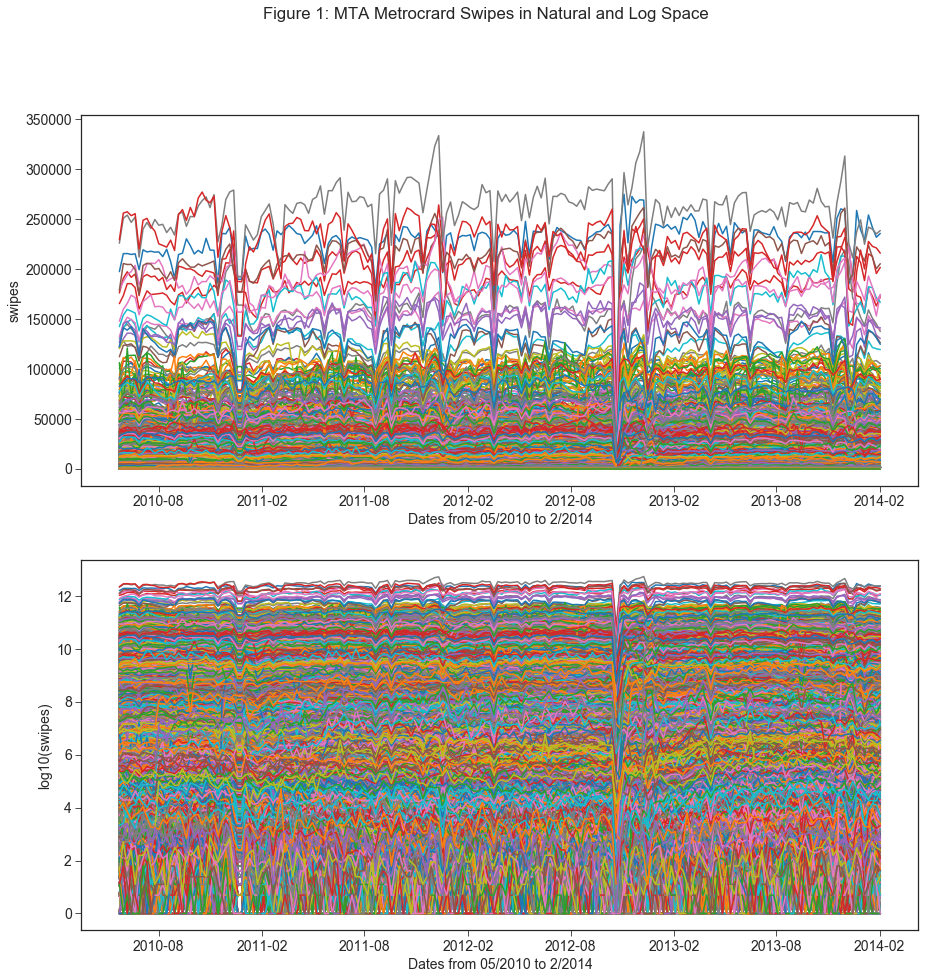

In [13]:
#Create the plots from HW 11
plt.rcParams.update({'font.size':14})
fig,(ax1,ax2) = plt.subplots(nrows = 2, ncols = 1, figsize = (15,15))
ax1.set(xlabel = 'Dates from 05/2010 to 2/2014', ylabel = 'swipes')
for i in range(len(mta)):
    for j in range(len(mta[i])):
        ax1.plot(dates,mta[i][j])
ax2.set(xlabel = 'Dates from 05/2010 to 2/2014', ylabel = 'log10(swipes)')
for i in range(len(mta)):
    for j in range(len(mta[i])):
        ax2.plot(dates,np.log(mta[i][j]))
plt.suptitle('Figure 1: MTA Metrocrard Swipes in Natural and Log Space')

Figure 1 shows the time series swipe data for all 600 subway stations over almost four years. It shows in both normal and log transformed y axes. An event is detectable in both plots, which occurs around the time of Hurrican Sandy, when the MTA was shut down.

In [12]:
#Compress the array over subway stations
subway_stations = np.nansum(mta, axis = 1)

In [21]:
#Turn the array into a data
station_data = pd.DataFrame(subway_stations, columns = pd.date_range(start = '05/09/2010', periods = 194, freq = 'w'))

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


Text(0.5,1,'Figure 2: FFT of all Subway Station Swipes')

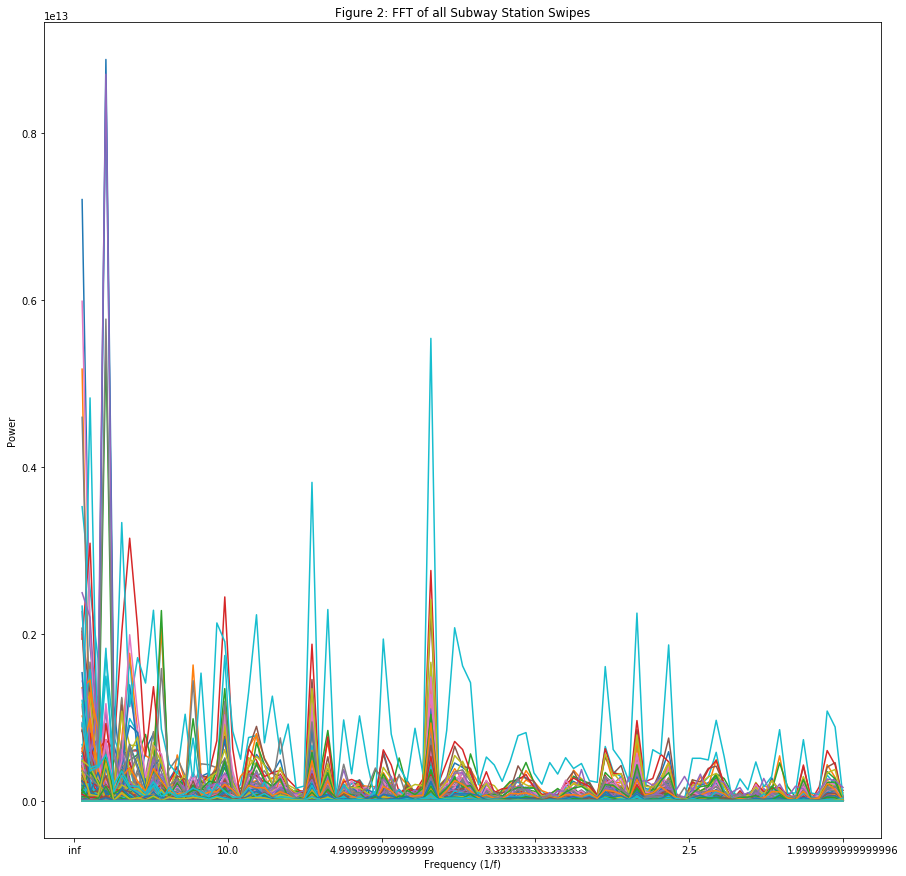

In [41]:
#Define sampling rate, distance, and n. Plot a FFT of all of the swipes time series per station
sr = 1 #Sampling Rate
d = 194 #Distance (194 weeks)
n = d * sr
fig = pl.figure(figsize = (15,15))
ax = fig.add_subplot(111)
for i in range(len(station_data)):
    f = np.abs(np.fft.rfft(subway_stations[i]))**2
    x = np.fft.rfftfreq(n, 1.0)
    ax.plot(x[1:], (f[1:]), '-')
ax.set_xticklabels(["%s"%(1/f) for f in ax.get_xticks()])
ax.set_xlabel("Frequency (1/f)")
ax.set_ylabel("Power")
ax.set_title('Figure 2: FFT of all Subway Station Swipes')

Figure 2 plots the fast fourrier transform (FFT) of all stations We do see some 'noise' at the beginning, which will be needed to determine which stations have the highest power, and therefore periodicity.

In [22]:
# Create an array for the fgrequencies and find which one corresponds to an annual period. 4 is 48.5 which is closest
# to 52 weeks
annual = 1/np.fft.rfftfreq(194,1)
print(annual)

[         inf 194.          97.          64.66666667  48.5
  38.8         32.33333333  27.71428571  24.25        21.55555556
  19.4         17.63636364  16.16666667  14.92307692  13.85714286
  12.93333333  12.125       11.41176471  10.77777778  10.21052632
   9.7          9.23809524   8.81818182   8.43478261   8.08333333
   7.76         7.46153846   7.18518519   6.92857143   6.68965517
   6.46666667   6.25806452   6.0625       5.87878788   5.70588235
   5.54285714   5.38888889   5.24324324   5.10526316   4.97435897
   4.85         4.73170732   4.61904762   4.51162791   4.40909091
   4.31111111   4.2173913    4.12765957   4.04166667   3.95918367
   3.88         3.80392157   3.73076923   3.66037736   3.59259259
   3.52727273   3.46428571   3.40350877   3.34482759   3.28813559
   3.23333333   3.18032787   3.12903226   3.07936508   3.03125
   2.98461538   2.93939394   2.89552239   2.85294118   2.8115942
   2.77142857   2.73239437   2.69444444   2.65753425   2.62162162
   2.58666667   2.552

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


Text(0.5,1,'Figure 2: FFT of all Subway Station Swipes Starting at Timestamp 2')

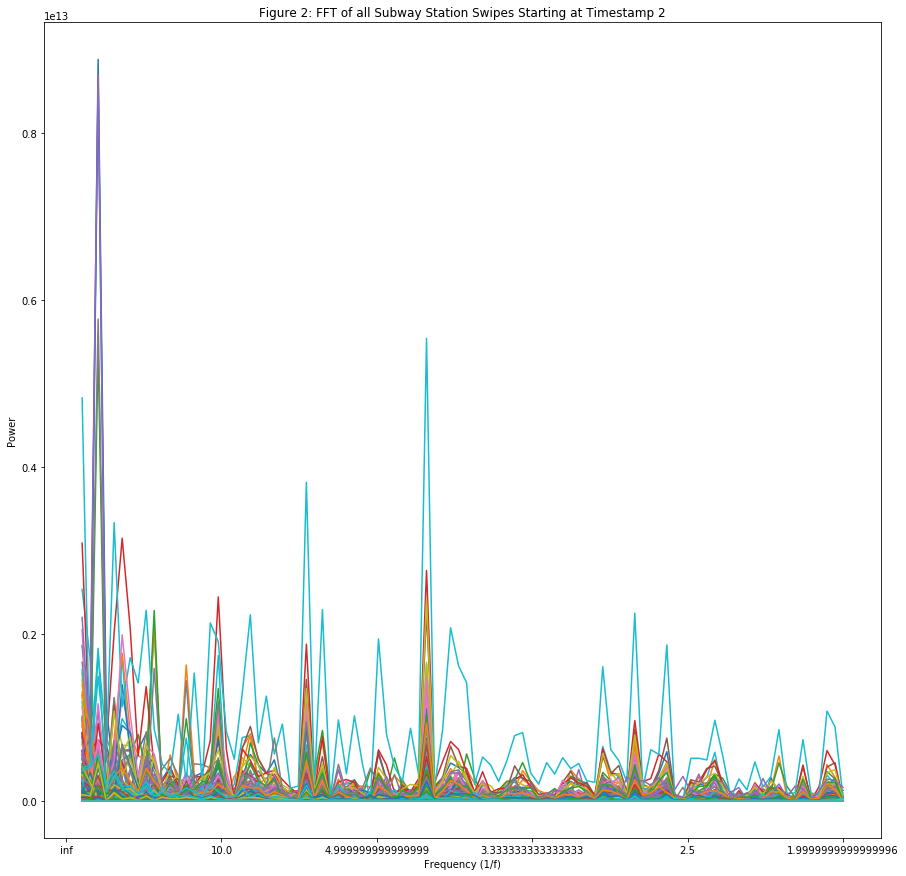

In [42]:
#Plot a FFT of all of the swipes time series per station starting at the second time steps
fig = pl.figure(figsize = (15,15))
ax = fig.add_subplot(111)
period_dict = {}

for i in range(len(station_data)):
    f = np.abs(np.fft.rfft(subway_stations[i]))**2
    x = np.fft.rfftfreq(n, 1.0)
    ax.plot(x[2:], (f[2:]), '-')
    period_dict[i] = f[4]
ax.set_xticklabels(["%s"%(1/f) for f in ax.get_xticks()])
ax.set_xlabel("Frequency (1/f)")
ax.set_ylabel("Power")
ax.set_title('Figure 2: FFT of all Subway Station Swipes Starting at Timestamp 2')

Figure 3 plots the fast fourrier transform (FFT) of all stations We do see some after noise has been filtered out. It is now more clear which stations have the highest power, and therefore periodicity at the beginning of the FFT.

In [28]:
#Which four time series have the highest power, and therefore highest periodicity.
top_periods = nlargest(4, period_dict, key = period_dict.get)
print("The four stations with the most prominent annual periodic trends:", top_periods)

The four stations with the most prominent annual periodic trends: [0, 194, 150, 327]


/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


Text(0.5,1,'Figure 4: FFT of the Swipes of the Four Most Periodic Stations')

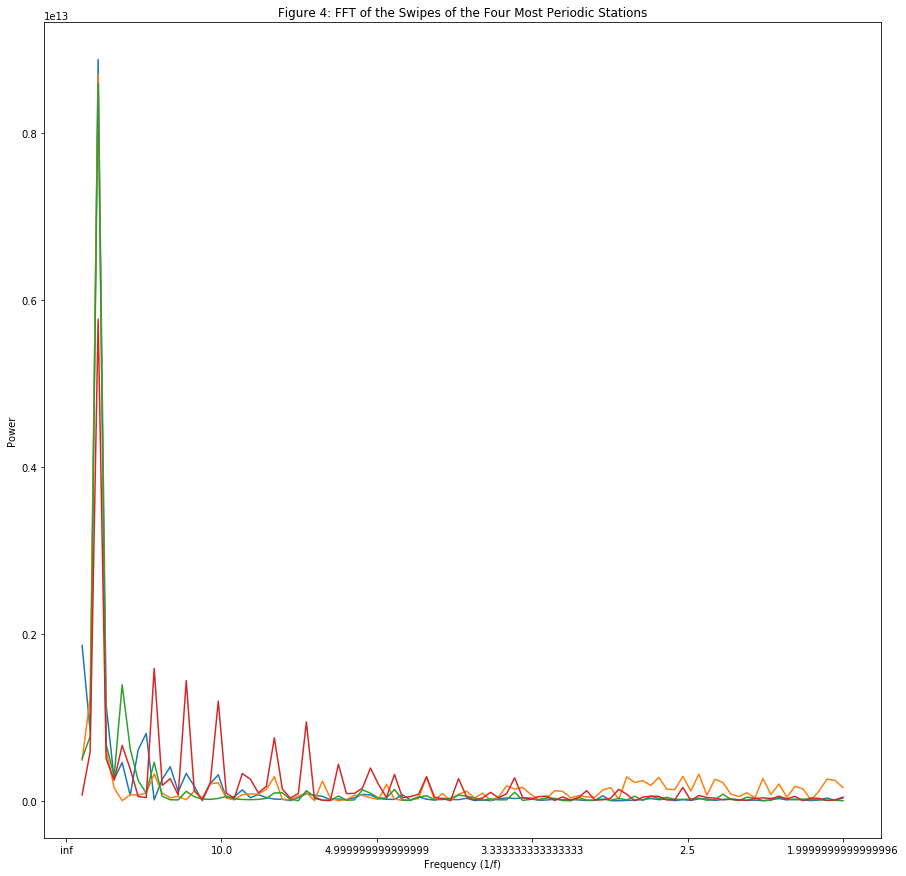

In [46]:
#Plot the four stations with the highest power, and therefore highest periodicity
fig = pl.figure(figsize = (15,15))
ax = fig.add_subplot(111)

for i in range(len(top_periods)):
    f = np.abs(np.fft.rfft(subway_stations[top_periods[i]]))**2
    x = np.fft.rfftfreq(n, 1.0)
    ax.plot(x[2:], (f[2:]), '-', label = 'Station ' + str(top_periods))
            
ax.set_xticklabels(["%s"%(1/f) for f in ax.get_xticks()])
ax.set_xlabel("Frequency (1/f)")
ax.set_ylabel("Power")
ax.set_title('Figure 4: FFT of the Swipes of the Four Most Periodic Stations')

Figure 4 shows the FFT of the four stations with the most periodic time series. We can see these four were found at the peak at the beginning of the FFT, which indicated that they were periodic. Removing the power values before that allow one to better identify these stations.

Text(0.5,1,'Figure 5: Time Series of the Swipes of the Four Most Periodic Stations')

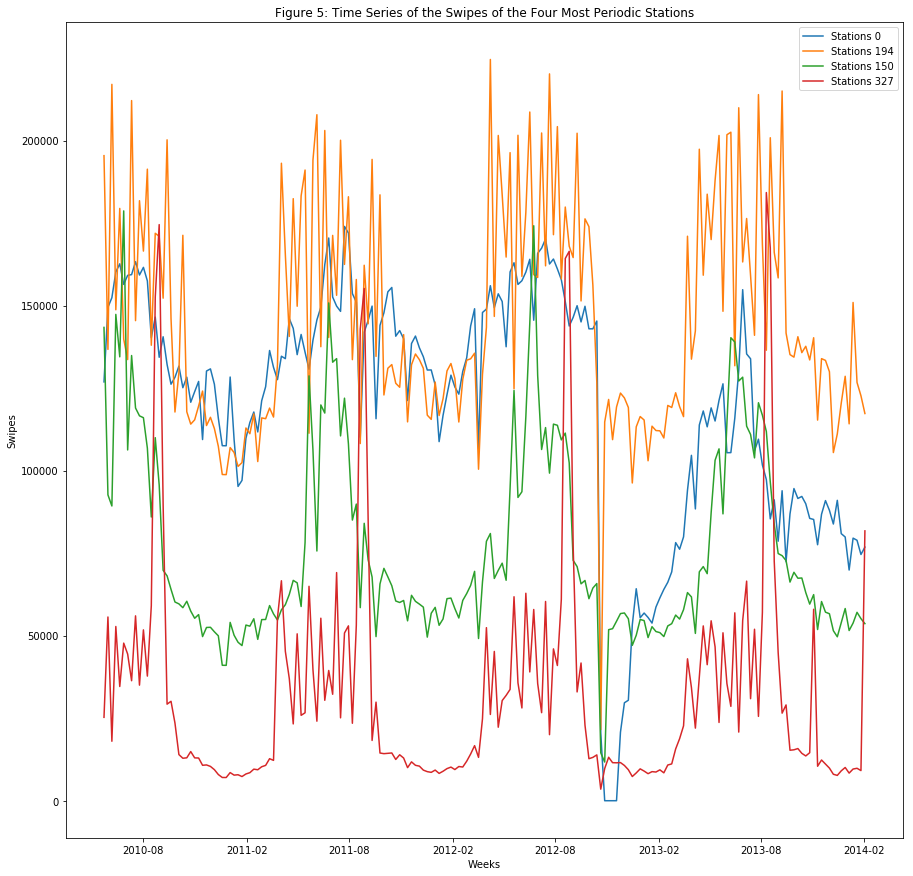

In [47]:
#Plot the time series of the four stations with the highest periodicity
fig = pl.figure(figsize = (15,15))
ax = fig.add_subplot(111)

for i in range(len(top_periods)):
    ax.plot(dates, subway_stations[top_periods[i]], '-', label="Stations " + str(top_periods[i]))
ax.set_xlabel("Weeks")
ax.set_ylabel("Swipes")
ax.legend(loc = 'best')
pl.xticks()
ax.set_title('Figure 5: Time Series of the Swipes of the Four Most Periodic Stations')

Figure 5 shows the time series of the stations in NYC with the most periodic swipes. The event in 2012 is Hurricane Sandy when the subway was shut down. Each of these time series are periodic through the year, where they are extensively entered in the summer months but are less utilized in the winter. Probably because peopel don't want to walk outside as much and might prefer private transportation. While attempting to identify these stations may be tough, it would appear that station 327 (red) would be a station that isn't used all that much in general and is only comparable in swipes to the other stations in summer. One might guess it is then the Rockaway stop on the A, which is flooded with people to go to the beach in the summer months, but is rarely used by people other than those from the Rockaways outside summer.